# Statistical modeling and Inference 
## José Fernando Moreno Gutiérrez (GSE-MDS138478)

### Problem set # 1 from slides

### Slides 1
#### Exercise 4
The code and graphics for this exercise are also available on Github:
* Code: https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R
* Graphics: https://github.com/chpmoreno/BGSE-DS-SMIPS/tree/master/lectures/1/Graphics

The folder R contains the file [MLE.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/mle.R) which contains three functions:

* mle_estimator_lm: the function produce the loglikelihood for a linear regression model asumming gaussian errors.
* mle_result: the function store and produce the principal results of the linear model that are used to produce the graphics.
* mle_plots: produce the three plots required for the excercise using gglot2.

Also contains the file [execution.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/execution.R) which uses the [MLE.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/1/R/mle.R) for making the graphics.

The following is basically the same programs with little changes for executing it on the present notebook.

**Functions**

In [1]:
mle_estimator_lm <- function (w, t_vector, phi) {
    if(is.vector(t_vector) == FALSE)
      t_vector <- as.vector(t_vector)
    if(is.matrix(phi) == FALSE)
      phi <- as.matrix(phi)
    M <- ncol(phi) 
    phi_w <- phi %*% w[1:M]
    Sig <- w[(M + 1):(M + 1)]
    sum(-(1 / 2) * log(2 * pi) - (1 / 2) * log(Sig ^ 2) - (1 / (2 * Sig ^ 2)) * (t_vector - phi_w) ^ 2)
}

mle_result <- function (mle_estimation_result, t_vector, phi) {
  phi        <- as.matrix(phi) 
  w          <- as.matrix(mle_estimation_result$par[-length(mle_estimation_result$par)])
  sigma      <- last(mle_estimation_result$par)
  variance   <- -solve(mle_estimation_result$hessian)
  w_se       <- sqrt(diag(variance))[1:length(w)]
  sigma_se   <- last(sqrt(diag(variance)))
  z_value    <- w/w_se
  p_value    <- 2 * (1 - pnorm(abs(z_value)))
  t_hat      <- phi %*% w 
  e          <- t_vector - t_hat
  e_st       <- e/sigma_se
  leverage   <- NULL 
  for(i in 1:nrow(phi)){
    leverage <- c(leverage, t(phi[i,]) %*% solve(t(phi) %*% phi) %*% phi[i,])
  }
  # leverage is equivalent to diag(phi %*% solve(t(phi) %*% phi) %*% t(phi))
  # diagonal of the hat matrix
  return(list(w = w, sigma = sigma, variance = variance, w_se = w_se, sigma_se = sigma_se,
              z_value = z_value, p_value = p_value, t_hat = t_hat, e = e, e_st = e_st,
              leverage = leverage, n = nrow(phi)))
}

mle_plots <- function(mle_results){
  ci_plot_data <- data.frame(coeff_number = seq(1:nrow(mle_results$w))) %>% 
                  bind_cols(data.frame(w = mle_results$w)) %>% 
                  mutate(lower_bound = w - 1.96 * mle_results$w_se) %>% 
                  mutate(upper_bound = w + 1.96 * mle_results$w_se) %>% 
                  mutate(color_ci = ifelse(mle_results$p_value < 0.05, "green", "red"))
  
  ci_plot <- ggplot(data = ci_plot_data, aes(x = as.factor(coeff_number), y = w)) + 
             geom_errorbar(aes(ymin = lower_bound, ymax = upper_bound), 
                           color = ci_plot_data$color_ci, width = 0.3) + 
             geom_point() + ggtitle("w estimation and confidence intervals") +
             labs(x = "Coefficient", y = "w, w +/- 1.96 s.e.") + theme_economist()
  
  st_res_plot_data <- data.frame(e_st = mle_results$e_st) %>% 
                      bind_cols(data.frame(t_hat = mle_results$t_hat)) %>% 
                      mutate(leverage_colour = ifelse(mle_results$leverage > 
                                                      (3 * (length(mle_results$w)) / mle_results$n ),
                                                      "red", "black"))
                       
  st_res_plot <- ggplot(data = st_res_plot_data, aes(x = t_hat, y = e_st)) + 
                 geom_point(color = st_res_plot_data$leverage_colour) + 
                 ggtitle("Standard error vs fitted") +
                 labs(x = "fitted values", y = "Standard error") + theme_economist()
  
  qq_plot_data <- qq(mle_results$e)
  
  qq_plot <- ggplot(qq_plot_data$qq_df, aes(x=z, y=ord.x)) +
    geom_abline(intercept = qq_plot_data$qq_coef[1], slope = qq_plot_data$qq_coef[2], color = "red") +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha=0.2, color = "cadetblue3", fill = "cadetblue2") +
    geom_point() +
    ggtitle("Q-Q plot") +
    labs(x = "Theoretical quantiles", y = "Standarized residuals") + theme_economist()
  
  return(list(ci_plot = ci_plot, st_res_plot = st_res_plot, qq_plot = qq_plot))
}

qq <- function(x, distribution = "norm", ..., line.estimate = NULL, conf = 0.95,
                  labels = names(x)){
  q.function <- eval(parse(text = paste0("q", distribution)))
  d.function <- eval(parse(text = paste0("d", distribution)))
  x <- na.omit(x)
  ord <- order(x)
  n <- length(x)
  P <- ppoints(length(x))
  df <- data.frame(ord.x = x[ord], z = q.function(P, ...))
  
  if(is.null(line.estimate)){
    Q.x <- quantile(df$ord.x, c(0.25, 0.75))
    Q.z <- q.function(c(0.25, 0.75), ...)
    b <- diff(Q.x)/diff(Q.z)
    coef <- c(Q.x[1] - b * Q.z[1], b)
  } else {
    coef <- coef(line.estimate(ord.x ~ z))
  }
  
  zz <- qnorm(1 - (1 - conf)/2)
  SE <- (coef[2]/d.function(df$z)) * sqrt(P * (1 - P)/n)
  fit.value <- coef[1] + coef[2] * df$z
  df$upper <- fit.value + zz * SE
  df$lower <- fit.value - zz * SE
  
  if(!is.null(labels)){ 
    df$label <- ifelse(df$ord.x > df$upper | df$ord.x < df$lower, labels[ord],"")
  }
  
  return(list(qq_df = df, qq_coef = coef))
}

**Code for creating the graphics**

In [ ]:
# load libraries and functions needed
library(dplyr)
library(ggplot2)
library(ggthemes)
library(grid)
library(gridExtra)
library(repr)
source("1/R/mle.R")

# initial parameters ####
m <- 30 # number of variables taken for the model

# load data - Find it on https://1drv.ms/t/s!Ai0XbELt7PXquFJtWenDbxvksoXM ####
file_location  <- "/home/chpmoreno/Documents/OneDrive/Documents/BGSE/First_Term/SMI/Datasets/synthetic_regression/synthetic_regression.txt"

data_exercise <- read.table(file = file_location,
                                  nrow = 300)[,1:(m + 1)]

# vector t (t_vector) and matrix phi
t_vector <- as.vector(data_exercise[ , "t"])
phi      <- cbind(rep(1, length(t_vector)), 
                  data_exercise[,-which(names(data_exercise) %in% c("t"))])
colnames(phi)[1] <- "const"

# mle_estimation
mle_estimation_result <- optim(runif(m + 2, 0, 1), mle_estimator_lm, phi = phi, 
                               t_vector = t_vector, method = "BFGS", 
                               control = list(trace = 1, maxit = 10000, fnscale = -1),
                               hessian = TRUE)

# mle_results
mle_results <- mle_result(mle_estimation_result, t_vector, phi)

# mle graphics
mle_graphics <- mle_plots(mle_results)

**printing the graphics**

*Graphic 1*

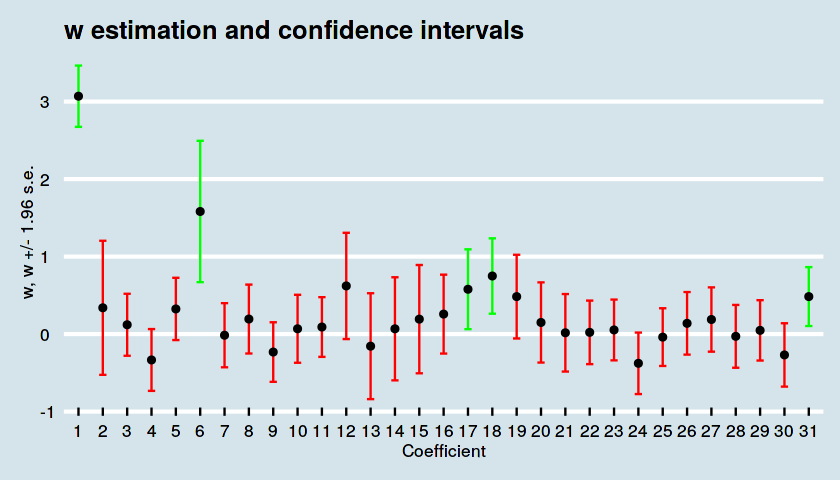

In [15]:
options(repr.plot.width=7, repr.plot.height=4)
print(mle_graphics$ci_plot)

*Graphic 2*

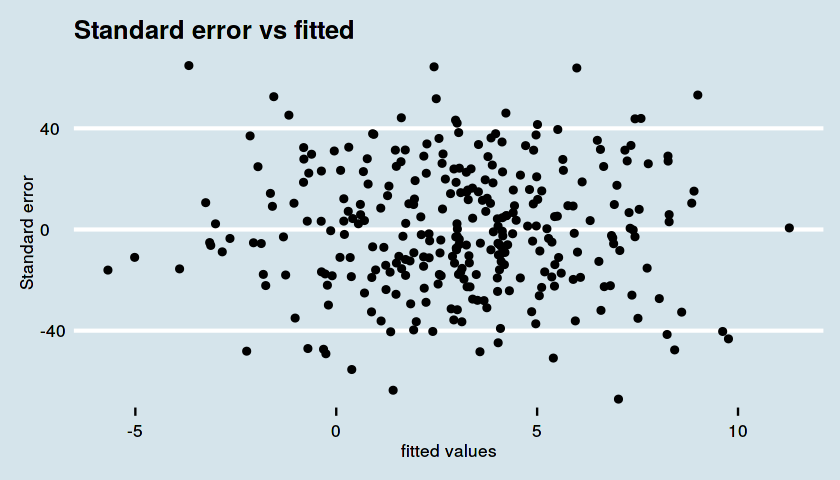

In [16]:
options(repr.plot.width=7, repr.plot.height=4)
print(mle_graphics$st_res_plot)

*Graphic 3*

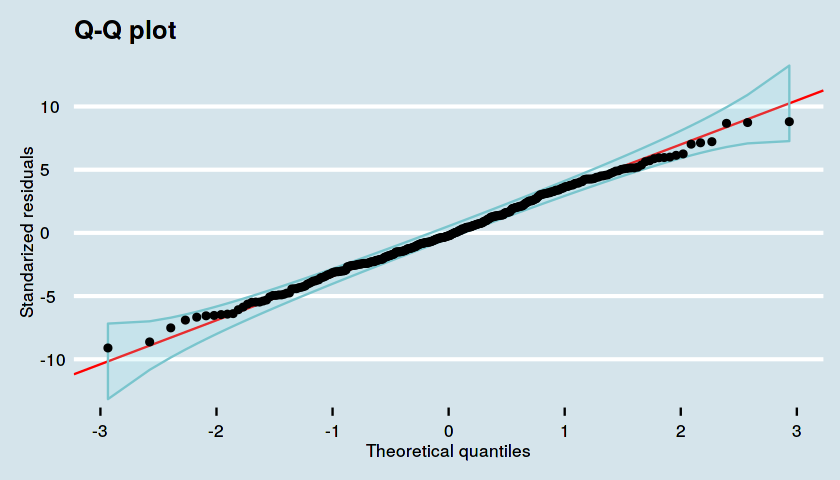

In [18]:
options(repr.plot.width=7, repr.plot.height=4)
print(mle_graphics$qq_plot)

### Slides 2
#### Exercise 2
The code and graphics for this exercise are also available on Github:
* Code: https://github.com/chpmoreno/BGSE-DS-SMIPS/tree/master/lectures/2/R
* Graphics: https://github.com/chpmoreno/BGSE-DS-SMIPS/tree/master/lectures/2/Graphics

The folder R contains the file [functions.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/2/R/functions.R) which contains the functions required in the exercise:

* phix: the function produce the features based on a basis.
* post.param: the function estimates $w$ and $Q$.

Also contains the file [execution.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/2/R/execution.R) which uses the [functions.R](https://github.com/chpmoreno/BGSE-DS-SMIPS/blob/master/lectures/2/R/functions.R) for making the graphics.

The following is basically the same programs with little changes for executing it on the present notebook.

**Functions**

In [19]:
phix <- function(x, M, basis) {
  if(basis == "poly"){
    X <- matrix(NA, ncol = M + 1, nrow = length(x))
    for(i in 0:M) {
      X[ , i + 1] <- x ^ i
    }
  }
  if(basis == "gauss") {
    means <- seq(0, 1, by = 1/M)
    X <- matrix(NA, ncol = M, nrow = length(x))
    for(i in 1:M) {
      X[, i] <- exp(-((x - means[i]) ^ 2) / 0.2) 
    }
  }
  return(X)
}

post.params <- function(training_data, M, basis_type, phix, delta, q){
  lambda   <- delta/q 
  t_vector <- training_data$t
  x        <- training_data$x
  X        <- phix(x, M, basis_type)
  w        <- solve(lambda * diag(1, ncol(X), ncol(X)) + (t(X) %*% X)) %*% t(X) %*% t_vector
  Q        <- q * (lambda * diag(1, ncol(X), ncol(X)) + (t(X) %*% X))
  return(ls = list(w=w, Q = Q))
}

**Code for creating the graphics**

In [ ]:
# load libraries and functions needed
source("2/R/functions.R")

# initial parameters ####
m <- 30 # number of variables taken for the model

# load data - Find it on https://1drv.ms/t/s!Ai0XbELt7PXquFJtWenDbxvksoXM ####
file_location  <- "/home/chpmoreno/Documents/OneDrive/Documents/BGSE/First_Term/SMI/Datasets/curve_data.txt"

#load # load data - Find it on  ####

data_exercise <- read.table(file = file_location)

plot_data <- ggplot(data = data_exercise, aes(x = x, y = t)) + 
             geom_point() + ggtitle("t / x scatter plot") + 
             theme_economist()

x_plot          <- seq(min(data_exercise$x), max(data_exercise$x), by = 1/1000)
w_poly_plot     <- post.params(data_exercise, 9, "poly", phix, 2, (1/0.1) ^ 2)$w
t_poly_hat_plot <- phix(x_plot, M = 9, "poly") %*% w_poly_plot
w_gauss_plot     <- post.params(data_exercise, 9, "gauss", phix, 2, (1/0.1) ^ 2)$w
t_gauss_hat_plot <- phix(x_plot, M = 9, "gauss") %*% w_gauss_plot

data_plot_model_poly  <- cbind(as.data.frame(x_plot), as.data.frame(t_poly_hat_plot), rep("poly", length(x_plot)))
data_plot_model_gauss <- cbind(as.data.frame(x_plot), as.data.frame(t_gauss_hat_plot), rep("gauss", length(x_plot)))
data_plot_real        <- cbind(data_exercise, rep("observed", nrow(data_exercise)))

colnames(data_plot_model_poly)  <- c("x", "t", "basis")
colnames(data_plot_model_gauss) <- c("x", "t", "basis")
colnames(data_plot_real)        <- c("x", "t", "basis")

data_plot_tot       <- bind_rows(data_plot_model_poly, data_plot_model_gauss, data_plot_real)

plot_tot <- ggplot(data = filter(data_plot_tot, basis == "observed"), aes(x = x, y = t, color = basis)) + 
            geom_point(size = 3) +
            geom_line(data = filter(data_plot_tot, basis == "poly"), aes(x = x, y = t, color = basis),
                      size = 0.8) +
            geom_line(data = filter(data_plot_tot, basis == "gauss"), aes(x = x, y = t, color = basis),
                      size = 0.8) +
            scale_colour_manual(values = c("limegreen", "blue", "red"),
                                guide = guide_legend(title = NULL,
                                                     override.aes = list(linetype = c("solid", "blank", "solid"),
                                                                         shape = c(NA, 16, NA)))) +
            ggtitle(expression(paste("t / x observed and estimated (M = 9, ", delta, " = 2, q = 100)"))) + 
            theme_economist()

**printing the graphics**

*Graphic 1*

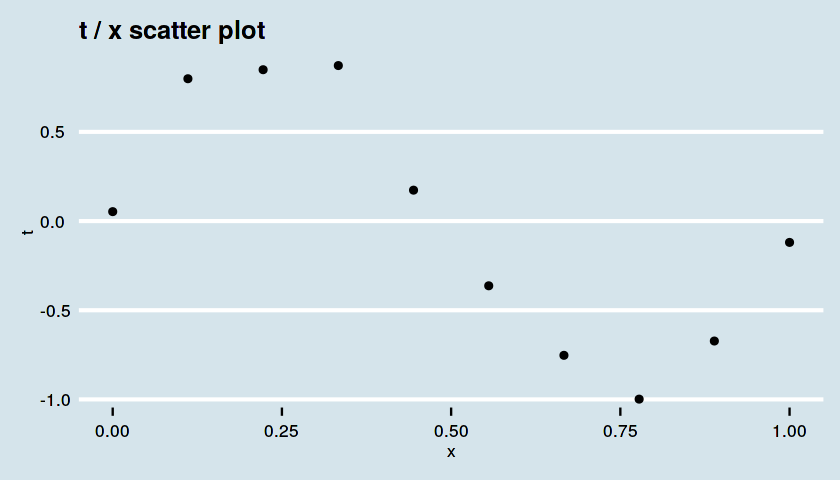

In [23]:
options(repr.plot.width=7, repr.plot.height=4)
print(plot_data)

*Graphic 2*

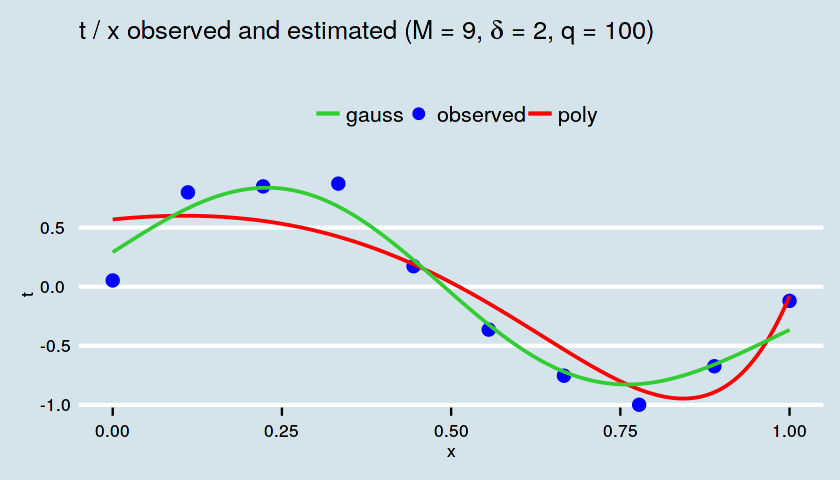

In [26]:
options(repr.plot.width=7, repr.plot.height=4)
print(plot_tot)

### Slides 3
#### Exercise 3

Let $\mathbf{K}$ be the matrix with $(n, k)$ element $k(\mathbf{x}_n , \mathbf{x}_k)$. Show that

\begin{equation*}
\mathbf{K} =  \mathbf{\Phi} \left(\lambda \mathbf{I} + \mathbf{\Phi}^T \mathbf{\Phi} \right)^{-1} \mathbf{\Phi}^T
\end{equation*}

Show that when $\lambda = 0$, and provided $\mathbf{\Phi}^T \mathbf{\Phi}$ is invertible,  $\mathbf{K}$ is precisely the “hat” matrix of linear regression. Therefore, the matrix of kernel weights provides a Bayesian version of such matrix. We will revisit this later in the course.
___

\begin{equation}
\mathbf{K} = \mathbf{\Phi} \left(\lambda \mathbf{I} + \mathbf{\Phi}^T \mathbf{\Phi} \right)^{-1} \mathbf{\Phi}^T =
 \begin{pmatrix}
  K_{11} &  &  \\
   & \ddots &  \\
   &  & K_{nn}
 \end{pmatrix}
\end{equation}

First define $\mathbf{P} = \left(\lambda \mathbf{I} + \mathbf{\Phi}^T \mathbf{\Phi} \right)^{-1}$. Then we have

\begin{equation}
\mathbf{K} = \mathbf{\Phi} \mathbf{P} \mathbf{\Phi}^T
\end{equation}

Also we know that

\begin{equation}
 \mathbf{\Phi} = 
 \begin{pmatrix}
   \Phi_{1}(x_1) &  & \Phi_{m}(x_1) \\
   & \ddots &  \\
  \Phi_{1}(x_n) &  & \Phi_{m}(x_n)
 \end{pmatrix}
\end{equation}

then using the information above we could see that

\begin{align*}
\mathbf{K}_{nk} &= \langle(\mathbf{\Phi} \mathbf{P})_{n\_},  (\mathbf{\Phi}^T)_{\_k}\rangle\\
	&= \langle \Phi^{T}(x_n)P,  (\Phi^T)_{-k}\rangle\\
	&= \langle \Phi^{T}(x_n)P,  \Phi(x_k)\rangle\\
	&= \Phi^{T}(x_n) \left(\lambda \mathbf{I} + \mathbf{\Phi}^T \mathbf{\Phi} \right)^{-1} \Phi(x_k)\\
	&= k(x_n, x_k)
\end{align*}

Now notice that if $\lambda=0$, $\mathbf{K=\Phi(\lambda I+\Phi^T\Phi)}^{-1}\mathbf{\Phi}^T=\mathbf{\Phi(\Phi^T\Phi)}^{-1}\mathbf{\Phi}^T=H$. $H$ is the "hat" matrix of linear regression.


### Slides 4
#### Exercise 2.1

*Suppose for simplicity that $a > 0$ ($a < 0$ can be handled in the same way), assume also that $\lambda > 0$ and consider the function*

\begin{equation*}
f\left(\mu \right) = \left(\mu - a\right)^2 + \lambda \left| \mu \right|
\end{equation*}

*Show that $\mu$ is minimised at $\left(a - \lambda / 2\right)^{+}$ where $x^{+}$ denotes the positive part of x.*
___
So we have

\begin{equation*}
f\left(\mu \right) = \mu^2 - 2\mu a + a^2 + \lambda \left| \mu \right|
\end{equation*}

then we take the first derivative of this function

\begin{equation*}
f'\left(\mu \right) = 2\mu - 2 a + \lambda \frac{\mu}{\left| \mu \right|}, \hspace{2mm} \mu \neq 0
\end{equation*}

Now to find the $\mu$ that minimise $f(\mu)$ 

\begin{equation*}
2\mu - 2 a + \lambda \frac{\mu}{\left| \mu \right|} = 0, \hspace{2mm} \mu \neq 0
\end{equation*}

Where we have the following two cases:

* $\mu^+$ $\left(\frac{\mu}{\left| \mu \right|} = 1\right)$, then

\begin{equation*}
\mu = \frac{2a - \lambda}{2} = a - \frac{1}{2} \lambda
\end{equation*}

* $\mu^-$ $\left(\frac{\mu}{\left| \mu \right|} = -1\right)$, then

\begin{equation*}
\mu = \frac{2a + \lambda}{2} = a + \frac{1}{2} \lambda
\end{equation*}

Then as $a>0$ and $\lambda > 0$ we know that

\begin{equation*}
a - \frac{1}{2} \lambda < a + \frac{1}{2}\lambda
\end{equation*}

Therefore it is an evidence that $\mu^+$ is minimised at $\left(a - \dfrac{1}{2} \lambda\right)^+$. To confirm that we are going to prove that $f'(\mu^+)$ is a minimum (recall that $\mu / \left| \mu \right|$ could be seen as a constant). Then

\begin{equation*}
f''(\mu^+) = 2
\end{equation*}

#### Exercise 2.2

*Consider now the Bayesian model $\mathbf{t_n}\sim N(\mathbf{w},q^{-1}I)$, where
the $t_n$s are conditionally independent given $\mathbf{w}$, with the prior $p\left(\mathbf{w}\right)\propto \exp\left({-\left(\frac{\delta}{2}\right)\sum\limits_i \left|w_i\right|}\right)$. Find $\mathbf{w_{MAP}}$ under this model in closed form. The marginal prior p$(w_i)$ on parameter $w_i$ is known as the Laplace distribution (aka the double exponential distribution).*
___
To begin with, decompose the posterior using Bayes

\begin{equation}
p(\mathbf{w}|\mathbf{x},\mathbf{t})\propto p(\mathbf{t}|\mathbf{w},\mathbf{x})p(\mathbf{w}).
\end{equation}

Now use the log-likelihood

\begin{equation}
-2\log\left(\text{p}(\mathbf{w}|\mathbf{x},\mathbf{t})\right)=-2\log \left(\mathbf{t}|\mathbf{w},\mathbf{x}\right)+-2\log\left(\text{p}(\mathbf{w})\right)+ c,
\end{equation}

Where $c$ is a constant. Then substitute the probabilities by the p.d.f of the distributions, $\mathbf{t}\sim N(\mathbf{w},q^{-1}I)$ and $p(\mathbf{w})= \exp \left({-\left(\frac{\delta}{2}\right)\sum\limits_i |w_i|}\right)$.

\begin{equation}
-2\log\left(\text{p}(\mathbf{w}|\mathbf{x},\mathbf{t})\right)=q(\mathbf{t}-\mathbf{w})^T(\mathbf{t}-\mathbf{w})+\delta\sum\limits_i w_i + c,
\end{equation}

If you expand the brackets,

\begin{equation}
l(\mathbf{w})=-2\log\left(\text{p}(\mathbf{w}|\mathbf{x},\mathbf{t})\right) = q(\mathbf{t}^T\mathbf{t}-\mathbf{t}^T\mathbf{w}-\mathbf{w}^T\mathbf{t}+\mathbf{w}^T\mathbf{w})+\delta\sum\limits_i w_i + c.
\end{equation}

Now computing the derivative for each $w_i$,

\begin{equation}
l'(\mathbf{w})=q(-2\mathbf{t}+2\mathbf{w})+\delta \mathbf{1}_w, 
\end{equation}

where $\mathbf{1}_w$ denotes the vector of 1's and -1's $\mathbf{1}_w=\left(\frac{w_1}{|w_1|},\dots,\frac{w_n}{|w_n|}\right)$. Taking $\lambda=\frac{\delta}{q}$ and equalying to 0

\begin{equation}
 -2\mathbf{t}+2\mathbf{w}+\lambda\mathbf{1}_w=0,
\end{equation}

rearranging the equation

\begin{equation}
\mathbf{w}=\mathbf{t}-\frac{\lambda}{2}\mathbf{1}_w.
\end{equation}

Finally using the same procedure as in **Exercise 2.1 (Slides 4)** for each of the components we obtain that $w_i=\left(t_i-\frac{\lambda}{2}\right)^+$, therefore

\begin{equation}
\mathbf{w_{MAP}}=\left(\mathbf{t}-\frac{\delta}{2q}\mathbf{1}\right)^+.
\end{equation}